# PyTorch Optimizer from Scratch

So far, we used optimizers pre-defined in ```torch.optim```, such as SGD, as below:

```
import torch.optim as optim
optimizer = optim.SGD(model.parameters(), lr=0.01)
```

In this tutorial, we will take a deeper look into how PyTorch optimizer works, and implement a few optimization algorithms from scratch.

(This tutorial is based on and modified from [this repository](https://github.com/bentrevett/a-tour-of-pytorch-optimizers/blob/main/a-tour-of-pytorch-optimizers.ipynb))

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import RandomSampler

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from tqdm import tqdm
import matplotlib.pyplot as plt

# https://pytorch.org/vision/stable/datasets.html
train_set = torchvision.datasets.MNIST(
    'D:/data', train=True, transform=transforms.ToTensor(), download=True)
test_set = torchvision.datasets.MNIST(
    'D:/data', train=False, transform=transforms.ToTensor(), download=True)

# This sampler will run for 5k training steps
# https://pytorch.org/docs/stable/data.html#torch.utils.data.RandomSampler
sampler = RandomSampler(train_set,
                        replacement=True,  # 복원 추출
                        num_samples=100 * 5000)  # batch_size x training_steps

# Use the sampler to create a data loader
train_loader = DataLoader(
    train_set, batch_size=100, sampler=sampler, num_workers=4)

# Test loader runs for 1 epoch
test_loader = DataLoader(
    test_set, batch_size=200, num_workers=4)

In [2]:

# define model

class MLP(nn.Module):
    def __init__(self):
        super().__init__()

        self.layer1 = nn.Linear(1 * 28 * 28, 256)  # MNIST image size
        self.layer2 = nn.Linear(256, 256)
        self.layer3 = nn.Linear(256, 128)
        self.layer4 = nn.Linear(128, 10)  # MNIST has 10 classes

    def init_params(self):
        for n, p in self.named_parameters():
            if 'weight' in n:
                nn.init.kaiming_normal_(p, nonlinearity='relu')
            elif 'bias' in n:
                nn.init.constant_(p, 0)

    def forward(self, x):
        # x: (B, 1, 28, 28)
        x = x.view(x.shape[0], -1)  # flatten, (B, 1*28*28)
        h1 = F.relu(self.layer1(x)) # (B, 256)
        h2 = F.relu(self.layer2(h1)) # (B, 256)
        h3 = F.relu(self.layer3(h2))  # (B, 128)
        return self.layer4(h3) # (B, 10)

In [3]:
# define training

def train(dataloader, model, optimizer, criterion, device):

    model.init_params()
    losses = []

    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        predictions = model(images)
        loss = criterion(predictions, labels)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

    return losses

@torch.no_grad()
def evaluate(dataloader, model, device):
    correct = 0
    total = 0
    for images, labels in tqdm(dataloader):
        images = images.to(device)
        labels = labels.to(device)
        predictions = model(images)
        correct += (predictions.argmax(dim=1) == labels).sum()
        total += len(labels)
    return (correct / total).item()

In [4]:
# helper functions for plotting losses
def plot_loss(loss, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the loss from a single experiment."""

    fig, ax = plt.subplots(figsize=figsize)
    ax.plot(loss)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()

def plot_losses(losses, labels, title=None, ymin=0, ymax=None, figsize=(15,5)):
    """Plots the losses from multiple experiments."""

    fig, ax = plt.subplots(figsize=figsize)
    for loss, label in zip(losses, labels):
        ax.plot(loss, label=label)
    ax.set_title(title)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Update Steps')
    ax.set_ylim(ymin=ymin, ymax=ymax)
    ax.grid()
    ax.legend(loc='upper right')


Inside the ```train``` function, optimizer is used twice: ```optimizer.zero_grad()``` and ```optimizer.step()```.

Now let's implement our first optimizer!

## Optimizer 1: Stochastic Gradient Descent (SGD)

Stochastic gradient descent is the simplest optimization algorithm, so it's a good place to start. We take our current model parameters $\theta_t$ and subtract the gradient of those parameters, $\nabla_\theta J(\theta_t)$, multiplied by the "learning rate", $\eta$.

The SGD algorithm is:

$$\theta_{t+1} = \theta_t - \eta \cdot \nabla_\theta J(\theta_t)$$

However, we don't just have one set of parameters, $\theta$, we have multiple parameters: the weights of layer 1, the biases of layer 1, the weights of layer 2, the biases of layer 2, etc. So we'll subscript the parameters with $i$:

$$\theta_{t+1,i} = \theta_{t,i} - \eta \cdot \nabla_\theta J(\theta_{t,i})$$

We subtract because we want to descend the gradient and move towards a lower loss value. Addition would ascend the gradient, hence it's called gradient ascent.

### Implementation

All optimizers need a way of keeping track of the parameters they're supposed to be updating (`model_params`) and a learning rate (`lr`). SGD in PyTorch doesn't have a default learning rate but `1e-3` is a common default learning rate value for other optimizers, so we use it here. All optimizers need a `zero_grad` function in order to remove the gradients calculated from the last update step, and a `step` function to perform a parameter update.

Note that any PyTorch method with a trailing underscore, e.g., `.sub_`, means the operation is in-place. This means our `step` function is updating each `param`, a tensor of parameters, in-place. These in-place operations are usually significantly faster than non in-place operations. It is also necessary in implementing PyTorch optimizer, **especially in updating the parameter value**.

In [5]:
import torch

class SGD:
    def __init__(self, model_params, lr=1e-3):
        self.model_params = list(model_params)
        self.lr = lr

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            if param.grad is not None:  # Ensure that gradients are available
                param.sub_(self.lr * param.grad)  # In-place update using the learning rate


In [6]:

model = MLP()
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

optimizer = SGD(model.parameters(), lr=1e-3)
sgd_loss = train(train_loader, model, optimizer, criterion, device)
sgd_acc = evaluate(test_loader, model, device)

print()
print(f"SGD test accuracy: {sgd_acc * 100:.2f}%")

100%|██████████| 50/50 [00:02<00:00, 18.09it/s]


SGD test accuracy: 89.12%


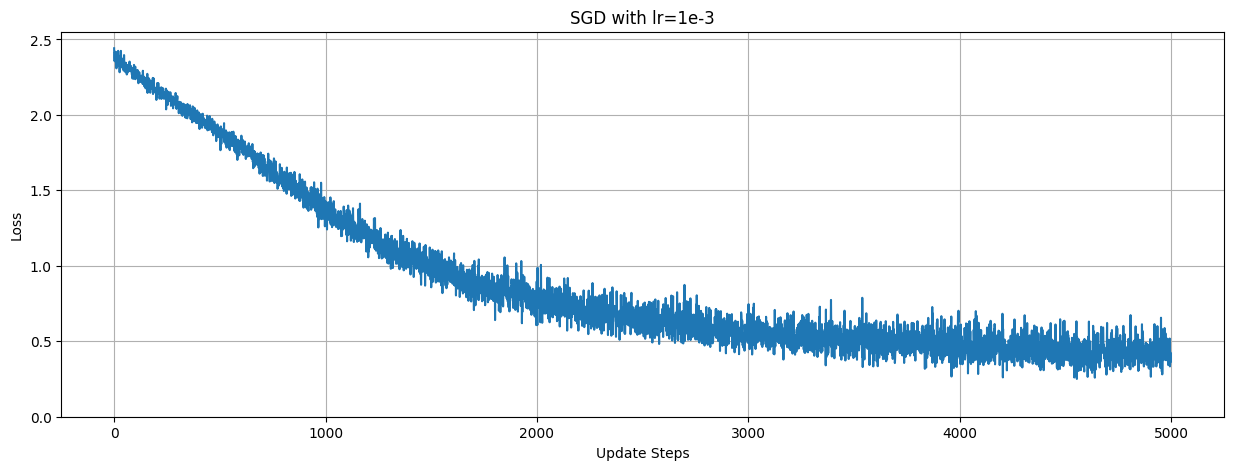

In [7]:
plot_loss(sgd_loss, 'SGD with lr=1e-3')


## Optimizer 2: SGD with Momentum

One way to think of SGD is a ball rolling down a hill, where areas of high gradient are steep parts of the hill and areas of low gradient are very flat areas. Sometimes the global minima, the point with the lowest loss, is in the middle of a giant flat area. The problem is that because these flat areas have small gradients they also give small update steps which makes learning slow.

What if we expanded on the "ball rolling down a hill" analogy? We'd want to add something to our optimizer that made it keep the "momentum" gained rolling down the steep hills whilst it's going across the flat areas.

Well hey, that's exact what SGD with momentum does! Our parameter update is now calculated using a velocity, $v$, which depends on the current gradient multiplied by the learning rate plus the previous velocity multiplied by the momentum $\gamma$.

\begin{align*}
    m_{t,i} &= \gamma \cdot m_{t-1,i} + \nabla_\theta J(\theta_{t,i})\\
    \theta_{t+1,i} &= \theta_{t,i} - \eta \cdot m_{t,i}\\
\end{align*}

Note that the velocity `v` is a list of tensors (initialized as zero) corresponding to the model parameters, so we are storing the velocity of every single parameter in our model.

In [8]:

class SGDMomentum:
    def __init__(self, model_params, lr=1e-3, momentum=0.9):
        self.model_params = list(model_params)
        self.lr = lr
        self.momentum = momentum  # gamma
        self.m = {p: torch.zeros_like(p) for p in self.model_params}  # Initialize momentum buffers

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            if param.grad is not None:  # Ensure gradient exists
                # Update the momentum buffer
                self.m[param] = self.momentum * self.m[param] + (1 - self.momentum) * param.grad
                # Apply the update step
                param.sub_(self.lr * self.m[param])  # In-place update using momentum-adjusted gradient


In [9]:

model = MLP()
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

optimizer = SGDMomentum(model.parameters(), lr=1e-3)
sgd_momentum_loss = train(train_loader, model, optimizer, criterion, device)

sgd_momentum_acc = evaluate(test_loader, model, device)

print()
print(f"SGDMomentum test accuracy: {sgd_momentum_acc * 100:.2f}%")

100%|██████████| 50/50 [00:02<00:00, 18.55it/s]


SGDMomentum test accuracy: 89.01%


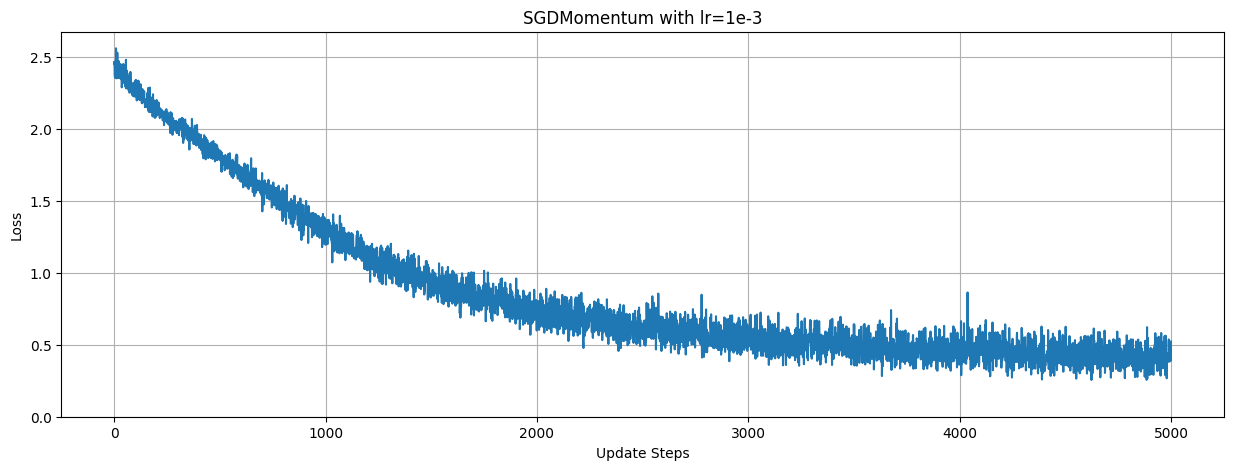

In [10]:
plot_loss(sgd_momentum_loss, 'SGDMomentum with lr=1e-3')

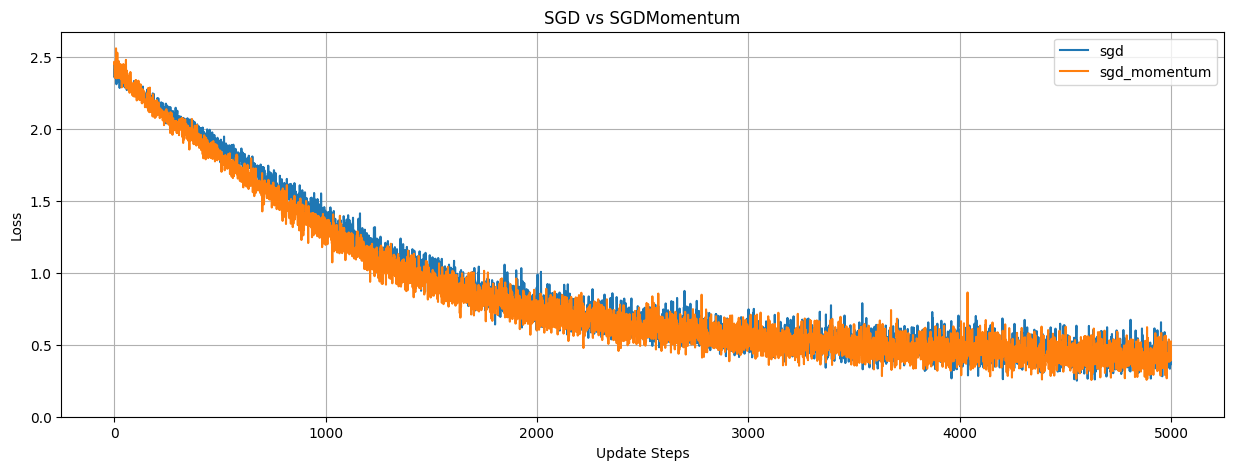

In [11]:
# Comparing SGD vs SGDMomentum

losses = [sgd_loss, sgd_momentum_loss]
labels = ['sgd', 'sgd_momentum']

plot_losses(losses, labels, 'SGD vs SGDMomentum')


## Optimizer 3: RMSProp

RMSProp solves the downside of AdaGrad that the accumulation of squared gradients from the beginning can cause an excessive decrease in the learning rate.

The solution suggested by RMSProp is to use the exponentially decaying average of sqaured gradient to discard history from the extreme past.

$$\theta_{t+1, i} = \theta_{t, i} - \frac{\eta}{\sqrt{v_{t,i}} + \epsilon} \cdot g_{t,i}$$

where:

\begin{align*}
    g_{t,i} &= \nabla_\theta J(\theta_{t,i}) \\
    v_{t,i} &= \rho v_{t-1,i} + (1-\rho)g_{t,i}^2 \\
\end{align*}

with $v$ initialized to zero.


In [12]:
import torch

class RMSProp:
    def __init__(self, model_params, lr=1e-2, rho=0.999, eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.rho = rho
        self.eps = eps
        # Initialize the moving average of squared gradients for each parameter
        self.v = {p: torch.zeros_like(p) for p in self.model_params}

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            if param.grad is not None:  # Ensure gradient exists
                # Update the moving average of squared gradients
                self.v[param] = self.rho * self.v[param] + (1 - self.rho) * param.grad ** 2
                # Update the parameter using the normalized gradient
                param.sub_(self.lr * param.grad / (torch.sqrt(self.v[param]) + self.eps))


In [13]:

model = MLP()
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

optimizer = RMSProp(model.parameters(), lr=1e-2)
rmsprop_loss = train(train_loader, model, optimizer, criterion, device)

rmsprop_acc = evaluate(test_loader, model, device)

print()
print(f"RMSProp test accuracy: {rmsprop_acc * 100:.2f}%")

100%|██████████| 50/50 [00:02<00:00, 17.86it/s]


RMSProp test accuracy: 93.68%


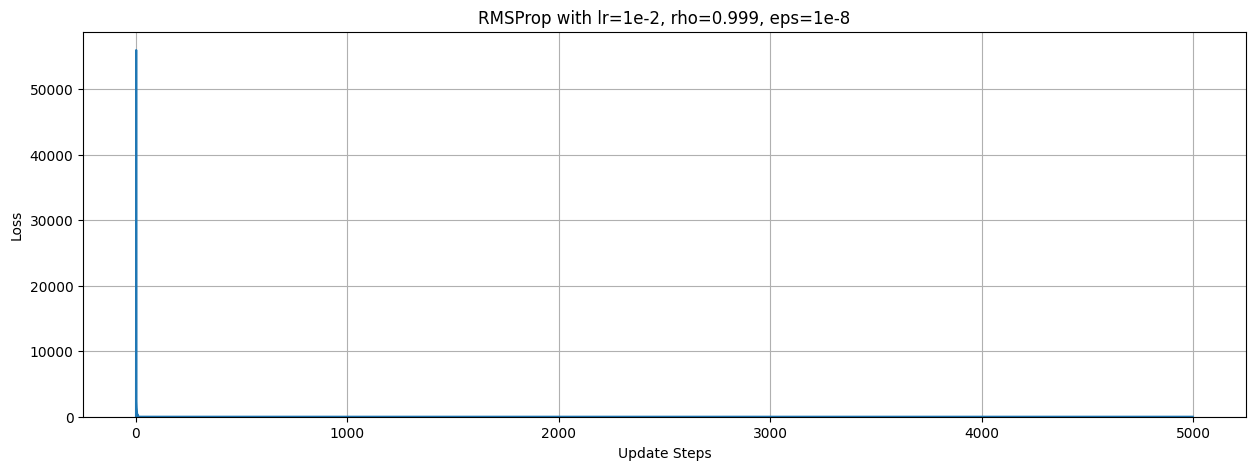

In [14]:
plot_loss(rmsprop_loss, 'RMSProp with lr=1e-2, rho=0.999, eps=1e-8')

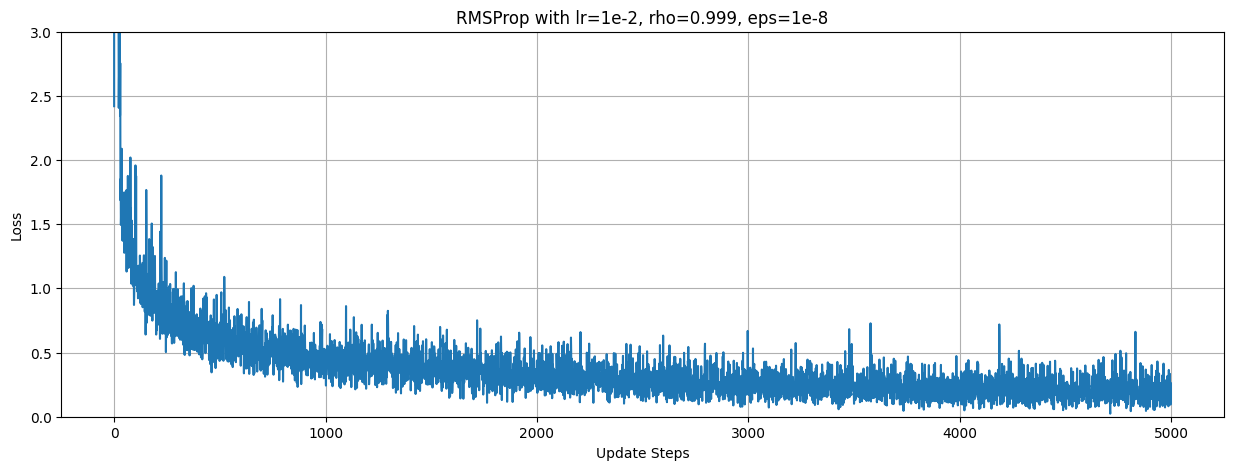

In [15]:
plot_loss(rmsprop_loss, 'RMSProp with lr=1e-2, rho=0.999, eps=1e-8', ymax=3.0)

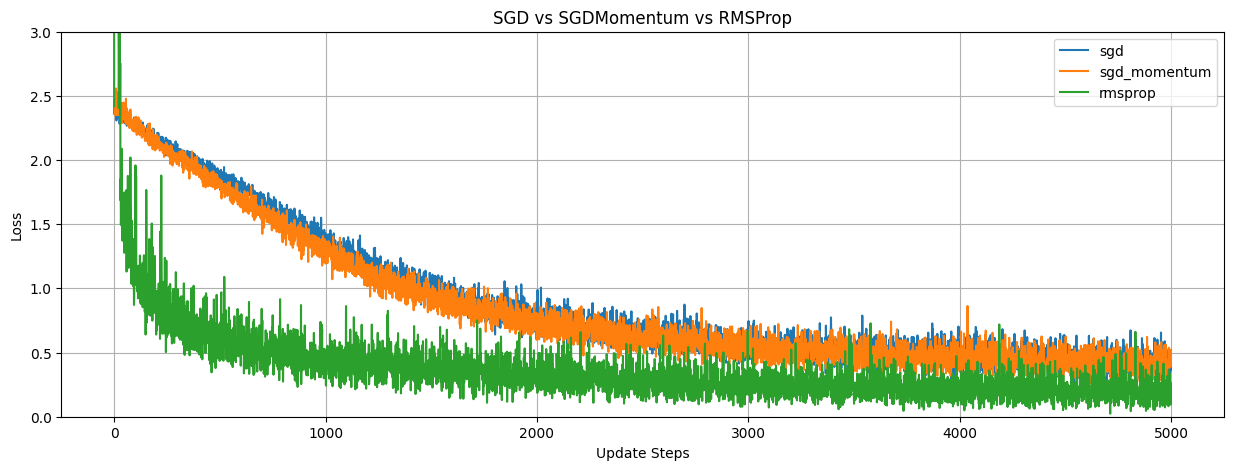

In [16]:
# Comparing SGD vs SGDMomentum vs Adam

losses = [sgd_loss, sgd_momentum_loss, rmsprop_loss]
labels = ['sgd', 'sgd_momentum', 'rmsprop']

plot_losses(losses, labels, 'SGD vs SGDMomentum vs RMSProp', ymax=3.0)


## Optimizer 4: Adam

Adam uses RMSprop's idea of annealing the step size over time by using an exponential moving average to avoid saturation, and also utilize the idea of momentum.

Adam has an exponential moving average of the gradients, like the momentum term that can be added to SGD, and an exponential moving average of squared gradients, like RMSprop.

$$\theta_{t+1, i} = \theta_t - \eta \cdot \frac{\hat{m}_{t,i}}{\sqrt{\hat{v}_{t,i}}+\epsilon}$$

where:

\begin{align*}
    m_{t,i} &= \beta_1 m_{t-1,i} + (1-\beta_1)g_{t,i} \\
    v_{t,i} &= \beta_2 v_{t-1,i} + (1-\beta_2)g_{t,i}^2 \\
    \hat{m}_{t,i} &= \frac{m_{t,i}}{1-\beta_1^t} \\
    \hat{v}_{t,i} &= \frac{v_{t,i}}{1-\beta_2^t}
\end{align*}

with $m$ and $v$ initialized to zero.

RMSProp and Momentum have problem that as $m$ and $v$ are initialized to zero and $\beta_1$ and $\beta_2$ are initialized close to one the $m$ and $v$ values calculated on the first few update steps are "biased" towards very small values.
(In RMSProp, this problem leads to spike in loss)

Adam solves these problems by using "bias corrected" values of $m$ and $v$, which are $\hat{m}$ and $\hat{v}$.

In [17]:

class Adam:
    def __init__(self, model_params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.eps = eps
        self.n_steps = 0
        # Initialize the first and second moment estimates
        self.m = {p: torch.zeros_like(p) for p in self.model_params}  # First moment (mean)
        self.v = {p: torch.zeros_like(p) for p in self.model_params}  # Second moment (variance)

    def zero_grad(self):
        for param in self.model_params:
            param.grad = None

    @torch.no_grad()
    def step(self):
        self.n_steps += 1
        for param in self.model_params:
            if param.grad is not None:  # Ensure gradient exists
                # Update biased first moment estimate
                self.m[param] = self.beta_1 * self.m[param] + (1 - self.beta_1) * param.grad
                # Update biased second moment estimate
                self.v[param] = self.beta_2 * self.v[param] + (1 - self.beta_2) * param.grad ** 2
                
                # Apply bias correction
                m_hat = self.m[param] / (1 - self.beta_1 ** self.n_steps)
                v_hat = self.v[param] / (1 - self.beta_2 ** self.n_steps)
                
                # Update parameter using the corrected moments
                param.sub_(self.lr * m_hat / (torch.sqrt(v_hat) + self.eps))


In [18]:

model = MLP()
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

optimizer = Adam(model.parameters(), lr=1e-3)
adam_loss = train(train_loader, model, optimizer, criterion, device)

adam_acc = evaluate(test_loader, model, device)

print()
print(f"Adam test accuracy: {adam_acc * 100:.2f}%")

100%|██████████| 50/50 [00:02<00:00, 17.49it/s]


Adam test accuracy: 97.88%


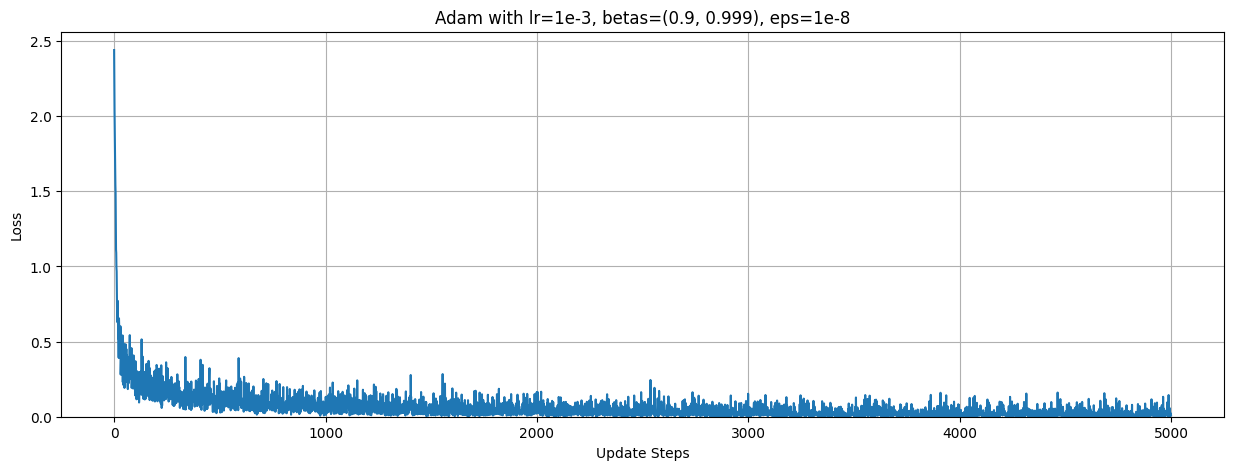

In [19]:
plot_loss(adam_loss, 'Adam with lr=1e-3, betas=(0.9, 0.999), eps=1e-8')

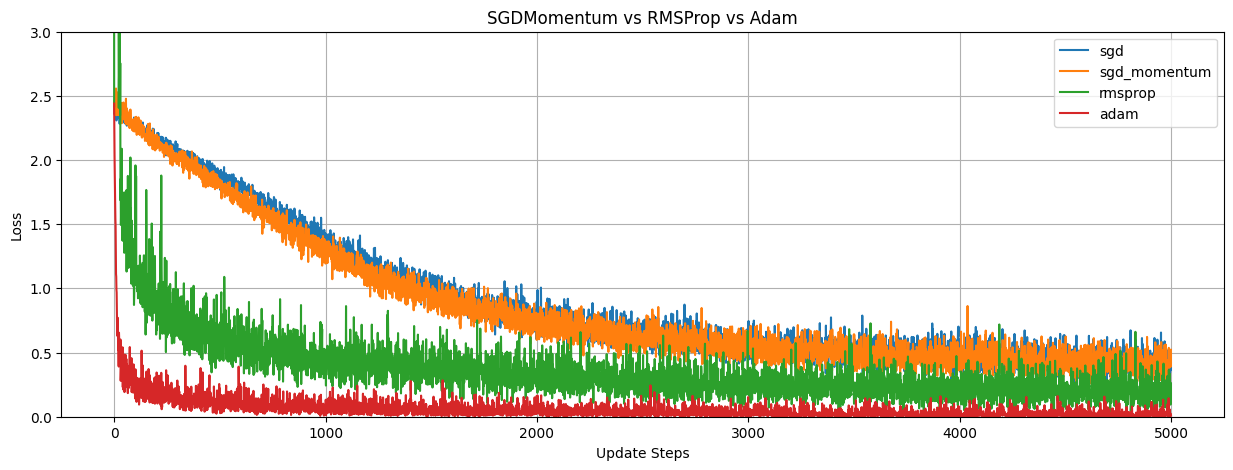

In [25]:
# Comparing SGD vs SGDMomentum vs Adam

losses = [sgd_loss, sgd_momentum_loss, rmsprop_loss, adam_loss]
labels = ['sgd', 'sgd_momentum', 'rmsprop', 'adam']

plot_losses(losses, labels, 'SGDMomentum vs RMSProp vs Adam', ymax=3.0)

## Optimizer 5: Lion

Unlike previous optimization algorithms which were hand-designed by human researchers, Lion was discovered via machine learning using the procedure called AutoML and evlutionary search.
Lion is known to perform better than AdamW (Adam with corrected weight decay) in large model training.

Below is the optimization step of Lion (without weight decay)

**Update model parameter**
\begin{align*}
    c_{t,i} &= \beta_1 m_{t-1,i} + (1 - \beta_1)g_{t,i} \\
    \theta_{t,i} &= \theta_{t-1,i} - \eta \ \text{sign}(c_{t,i}) \\
\end{align*}
where $\text{sign}$ is a function that returns 1 if input is larger than 0, 0 if equal to 0, and -1 otherwise. $m$ is initialized as zero.

**Update $m_t$**
\begin{align*}
    m_{t,i} &= \beta_2 m_{t-1, i} + (1 - \beta_2) g_{t, i}
\end{align*}

Reference: Chen et al., [*Symbolic Discovery of Optimization Algorithms*](https://arxiv.org/pdf/2302.06675) (2023)

In [30]:
import torch

class Lion:
    def __init__(self, model_params, lr=1e-4, betas=(0.9, 0.99)):
        self.model_params = list(model_params)
        self.lr = lr
        self.beta_1, self.beta_2 = betas
        self.m = {param: torch.zeros_like(param) for param in self.model_params}  # m 초기화

    def zero_grad(self):
        for param in self.model_params:
            if param.grad is not None:
                param.grad.zero_()

    @torch.no_grad()
    def step(self):
        for param in self.model_params:
            if param.grad is None:
                continue

            g_t = param.grad  # 현재 기울기
            m_prev = self.m[param]  # 이전 m 값

            # c_t 계산
            c_t = self.beta_1 * m_prev + (1 - self.beta_1) * g_t

            # 파라미터 업데이트 (sign 함수 사용)
            param -= self.lr * torch.sign(c_t)

            # m_t 업데이트
            self.m[param] = self.beta_2 * m_prev + (1 - self.beta_2) * g_t


In [31]:

model = MLP()
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

optimizer = Lion(model.parameters(), lr=1e-4)  # it is recommended to use smaller lr in Lion than in AdamW, which is Adam with decoupled weight decay
lion_loss = train(train_loader, model, optimizer, criterion, device)

lion_acc = evaluate(test_loader, model, device)

print()
print(f"Lion test accuracy: {lion_acc * 100:.2f}%")

100%|██████████| 50/50 [00:02<00:00, 18.60it/s]


Lion test accuracy: 97.74%


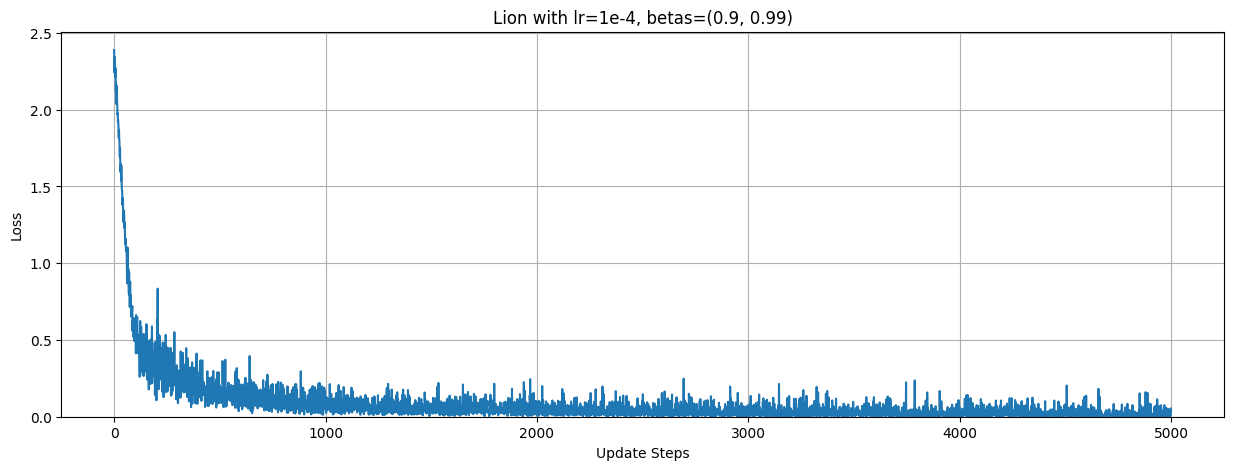

In [32]:
plot_loss(lion_loss, 'Lion with lr=1e-4, betas=(0.9, 0.99)')

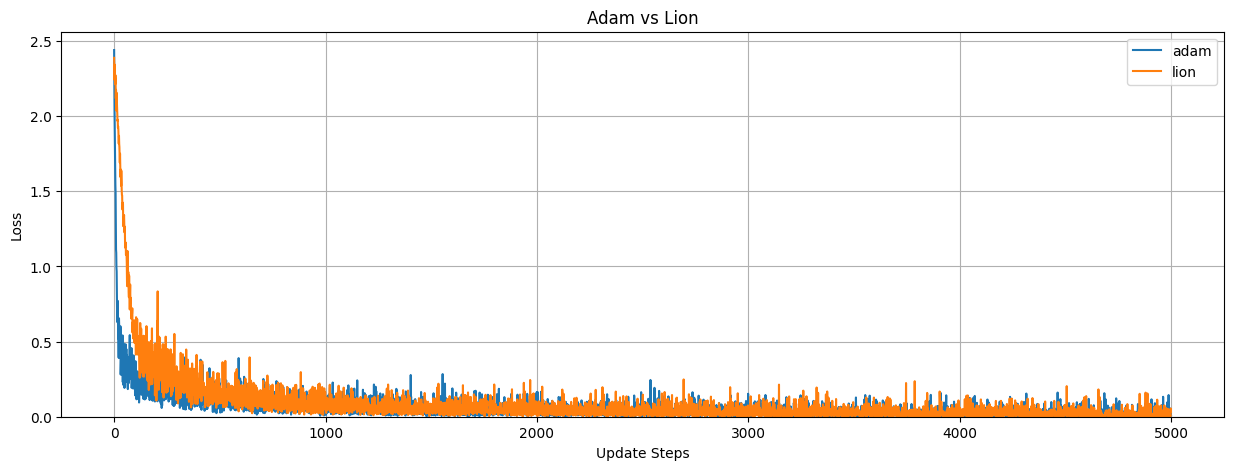

In [33]:
# Comparing Adam vs Lion

losses = [adam_loss, lion_loss]
labels = ['adam', 'lion']

plot_losses(losses, labels, 'Adam vs Lion')

## (Optional) Weight decay, param group, and inheriting torch.optim.Optimizer class

The optimizers that we have implemented so far works well in our setting, but is not generalizable if we need
1. weight decay
2. different hyperparameter (e.g., learning rate, weight decay) for different parameter groups


Example of using param_group to apply different hyperparameter for different parameters (from [OpenCLIP implementation](https://github.com/mlfoundations/open_clip/blob/main/src/open_clip_train/main.py))

```
exclude = lambda n, p: p.ndim < 2 or "bn" in n or "ln" in n or "bias" in n or 'logit_scale' in n
include = lambda n, p: not exclude(n, p)

named_parameters = list(model.named_parameters())
gain_or_bias_params = [p for n, p in named_parameters if exclude(n, p) and p.requires_grad]
rest_params = [p for n, p in named_parameters if include(n, p) and p.requires_grad]
optimizer = optim.AdamW(
    [
        {"params": gain_or_bias_params, "weight_decay": 0.},
        {"params": rest_params, "weight_decay": args.wd},
    ],
    lr=args.lr,
    betas=(args.beta1, args.beta2),
    eps=args.eps,
)
```

While the first limitation can be easily handled based on our code, the second limitation cannot. In this case, inheriting ```torch.optim.Optimizer``` class can be a solution.


Below is Lion optimizer (with weight decay) implemented by inheriting ```torch.optim.Optimizer``` class

In [34]:
# copied and modified from https://github.com/jettify/pytorch-optimizer/blob/master/torch_optimizer/lion.py

class CorrectLion(torch.optim.Optimizer):

    def __init__(
        self,
        params,
        lr: float = 1e-4,
        betas = (0.9, 0.99),
        weight_decay: float = 0.0,
    ):
        if lr <= 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 0: {}".format(betas[0])
            )
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(
                "Invalid beta parameter at index 1: {}".format(betas[1])
            )
        if weight_decay < 0:
            raise ValueError(
                "Invalid weight_decay value: {}".format(weight_decay)
            )
        defaults = dict(lr=lr, betas=betas, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @torch.no_grad()
    def step(self, closure = None):
        r"""Performs a single optimization step.

        Arguments:
            closure: A closure that reevaluates the model and returns the loss.
        """
        loss = None
        if closure is not None:
            with torch.enable_grad():
                loss = closure()

        for group in self.param_groups:
            for p in group["params"]:
                if p.grad is None:
                    continue

                # Perform stepweight decay
                p.data.mul_(1 - group["lr"] * group["weight_decay"])

                grad = p.grad
                state = self.state[p]
                # State initialization
                if len(state) == 0:
                    # Exponential moving average of gradient values
                    state["exp_avg"] = torch.zeros_like(p)

                exp_avg = state["exp_avg"]
                beta1, beta2 = group["betas"]

                # Weight update
                update = exp_avg * beta1 + grad * (1 - beta1)
                p.add_(torch.sign(update), alpha=-group["lr"])
                # Decay the momentum running average coefficient
                exp_avg.mul_(beta2).add_(grad, alpha=1 - beta2)

        return loss

In [35]:

model = MLP()
criterion = nn.CrossEntropyLoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = model.to(device)
criterion = criterion.to(device)

optimizer = CorrectLion(model.parameters(), lr=1e-4, weight_decay=1.0)
correct_lion_loss = train(train_loader, model, optimizer, criterion, device)

correct_lion_acc = evaluate(test_loader, model, device)

print()
print(f"CorrectLion test accuracy: {correct_lion_acc * 100:.2f}%")

100%|██████████| 50/50 [00:02<00:00, 18.08it/s]


CorrectLion test accuracy: 97.61%


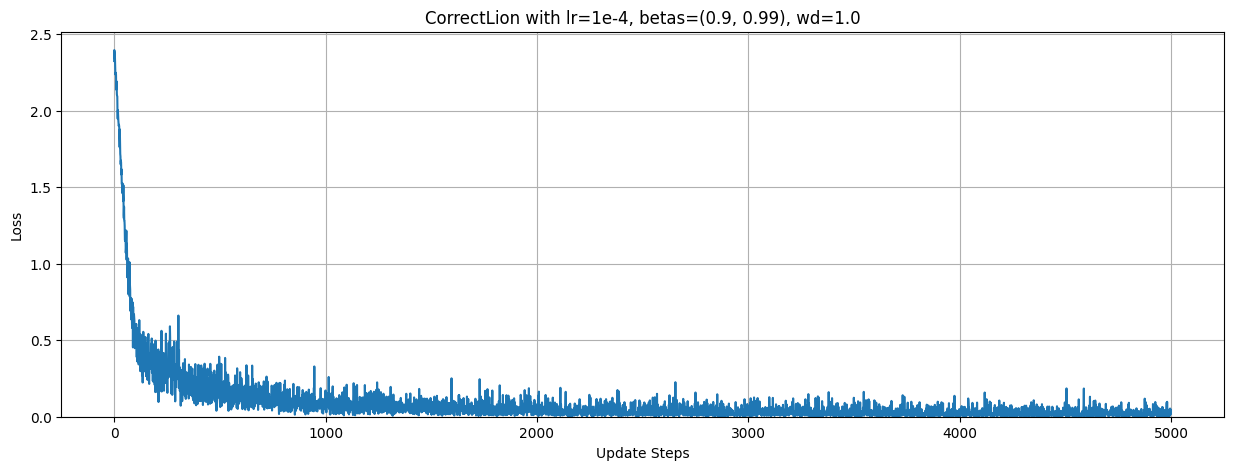

In [36]:
plot_loss(correct_lion_loss, 'CorrectLion with lr=1e-4, betas=(0.9, 0.99), wd=1.0')

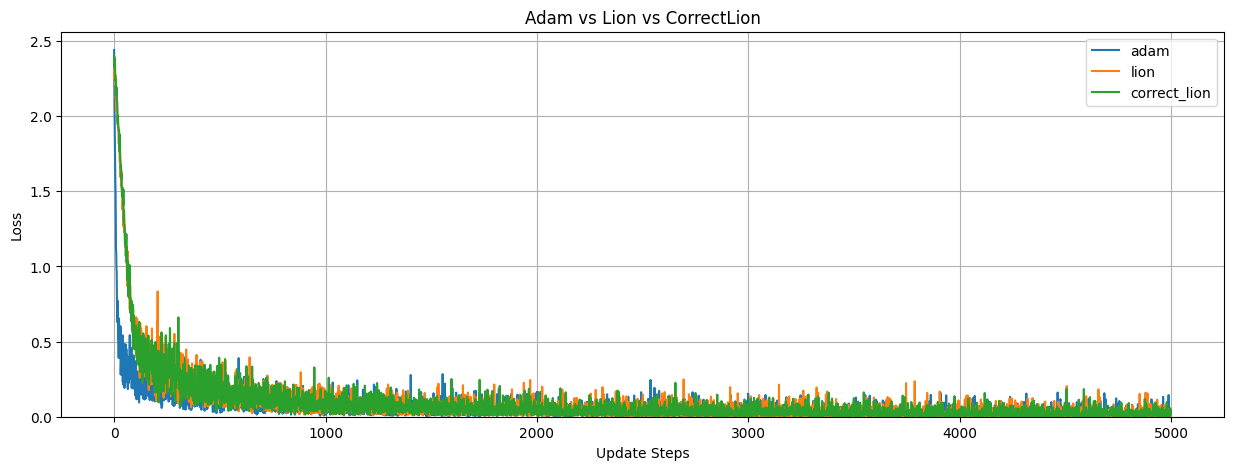

In [37]:
# Comparing Adam vs Lion vs CorrectLion

losses = [adam_loss, lion_loss, correct_lion_loss]
labels = ['adam', 'lion', 'correct_lion']

plot_losses(losses, labels, 'Adam vs Lion vs CorrectLion')

If you are interested in optimizers not implemented in ```torch.optim``` (such as Lion, Lars, AdaFactor, ...), searching [pytorch-optimizer](https://github.com/jettify/pytorch-optimizer/tree/master) can be an option.
